In [237]:
!pip install selectolax
!pip install aiohttp

In [309]:
from datetime import datetime, timedelta
import asyncio
import aiohttp
from dateutil.relativedelta import relativedelta
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [239]:
import requests
from selectolax.parser import HTMLParser
import re
import time

def fetch_dropdown_values(url):
    start_time = time.time()

    response = requests.get(url)
    if response.status_code == 200:
        tree = HTMLParser(response.text)
        dropdown = tree.css_first('select.form-control.dropdown')
        if dropdown:
                dropdown_values = [option.attributes['value'] for option in dropdown.css('option')
                               if 'value' in option.attributes and not any(char.isdigit() for char in option.attributes['value'])]
        else:
            print("Dropdown not found.")
            dropdown_values = []
    else:
        print(f"Error fetching dropdown values: {response.status_code}")
        dropdown_values = []

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken to fetch dropdown values: {elapsed_time:.2f} seconds")

    return dropdown_values

base_url = "https://www.mse.mk/en/stats/symbolhistory/kmb"
dropdown_values = fetch_dropdown_values(base_url)

filtered_values = [value for value in dropdown_values if not any(char.isdigit() for char in value)]

print(filtered_values)

Time taken to fetch dropdown values: 2.75 seconds
['ADIN', 'ALK', 'ALKB', 'AMBR', 'AMEH', 'APTK', 'ATPP', 'AUMK', 'BANA', 'BGOR', 'BIKF', 'BIM', 'BLTU', 'CBNG', 'CDHV', 'CEVI', 'CKB', 'CKBKO', 'DEBA', 'DIMI', 'EDST', 'ELMA', 'ELNC', 'ENER', 'ENSA', 'EUHA', 'EUMK', 'EVRO', 'FAKM', 'FERS', 'FKTL', 'FROT', 'FUBT', 'GALE', 'GDKM', 'GECK', 'GECT', 'GIMS', 'GRDN', 'GRNT', 'GRSN', 'GRZD', 'GTC', 'GTRG', 'IJUG', 'INB', 'INDI', 'INEK', 'INHO', 'INOV', 'INPR', 'INTP', 'JAKO', 'JULI', 'JUSK', 'KARO', 'KDFO', 'KJUBI', 'KKFI', 'KKST', 'KLST', 'KMB', 'KMPR', 'KOMU', 'KONF', 'KONZ', 'KORZ', 'KPSS', 'KULT', 'KVAS', 'LAJO', 'LHND', 'LOTO', 'LOZP', 'MAGP', 'MAKP', 'MAKS', 'MB', 'MERM', 'MKSD', 'MLKR', 'MODA', 'MPOL', 'MPT', 'MPTE', 'MTUR', 'MZHE', 'MZPU', 'NEME', 'NOSK', 'OBPP', 'OILK', 'OKTA', 'OMOS', 'OPFO', 'OPTK', 'ORAN', 'OSPO', 'OTEK', 'PELK', 'PGGV', 'PKB', 'POPK', 'PPIV', 'PROD', 'PROT', 'PTRS', 'RADE', 'REPL', 'RIMI', 'RINS', 'RZEK', 'RZIT', 'RZIZ', 'RZLE', 'RZLV', 'RZTK', 'RZUG', 'RZUS', 'SBT'

In [240]:
def generate_date_ranges(start_years_ago=10):
    end_date = datetime.now()
    start_date = end_date - relativedelta(years=start_years_ago)
    date_ranges = []

    current_start_date = start_date
    while current_start_date < end_date:
        current_end_date = current_start_date + relativedelta(years=1)
        if current_end_date > end_date:
            current_end_date = end_date

        date_ranges.append((
            current_start_date.strftime('%Y-%m-%d'),  # Changed format here
            current_end_date.strftime('%Y-%m-%d')     # Changed format here
        ))

        current_start_date = current_end_date

    return date_ranges

In [241]:
print(generate_date_ranges(10))

[('2014-12-28', '2015-12-28'), ('2015-12-28', '2016-12-28'), ('2016-12-28', '2017-12-28'), ('2017-12-28', '2018-12-28'), ('2018-12-28', '2019-12-28'), ('2019-12-28', '2020-12-28'), ('2020-12-28', '2021-12-28'), ('2021-12-28', '2022-12-28'), ('2022-12-28', '2023-12-28'), ('2023-12-28', '2024-12-28')]


In [242]:
def safe_float(value, default_value=0.0):
    try:
        value = value.strip().replace(',', '')
        value = value.replace(',', '.')
        return float(value)
    except (ValueError, AttributeError):
        return 0.0

In [243]:
async def fetch_data_for_code(session, url, start_date, end_date, code):
    data = {
        'FromDate': start_date,
        'ToDate': end_date,
        'Code': code
    }

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:132.0) Gecko/20100101 Firefox/132.0',
        'Content-Type': 'application/x-www-form-urlencoded',
        'Referer': url,
        'Origin': 'https://www.mse.mk'
        }

    async with session.post(url, data=data, headers=headers) as response:
        if response.status == 200:
            #print(f"Data fetched successfully for {code}: {start_date} to {end_date}")

            page = await response.text()
            tree = HTMLParser(page)

            rows = tree.css('table tr')
            data = []

            for row in rows:
                cells = row.css('td')
                if len(cells) > 8:
                    date = cells[0].text()
                    last_transaction_price = cells[1].text().replace(',', '.')
                    max_price = cells[2].text().replace(',', '.')
                    min_price = cells[3].text().replace(',', '.')
                    avg_price = cells[4].text().replace(',', '.')
                    percent_change = cells[5].text().replace(',', '.')
                    quantity = safe_float(cells[6].text())
                    best_traded = safe_float(cells[7].text())
                    total_traded = safe_float(cells[8].text())

                    if total_traded > 0 and quantity > 0:
                        data.append({
                            "code": code,
                            "date": date,
                            "last_transaction_price": last_transaction_price,
                            "max_price": max_price,
                            "min_price": min_price,
                            "avg_price": avg_price,
                            "percent_change": percent_change,
                            "quantity": quantity,
                            "best_traded": best_traded,
                            "total_traded": total_traded,

                        })
            return data
        else:
            error_text = await response.text()
            print(f"Error fetching data for {start_date} to {end_date} and code {code}: {response.status}")
            print(f"Response Content: {error_text}")
            return []

async def main(dropdown_values):
    date_ranges = generate_date_ranges(start_years_ago=10)
    all_data = []

    async with aiohttp.ClientSession() as session:
        tasks = []

        for code in dropdown_values:
            #print(f"Fetching data for code: {code}")


            for start_date, end_date in date_ranges:
                task = fetch_data_for_code(session, base_url, start_date, end_date, code)
                tasks.append(task)


        results = await asyncio.gather(*tasks)


        all_data = [item for sublist in results for item in sublist]

        #print(f"Fetched {len(all_data)} records")


        for record in all_data:
            print(record)

        return all_data

start_time = time.time()
data = await main(dropdown_values=dropdown_values)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to fetch values: {elapsed_time:.2f} seconds")

Streaming output truncated to the last 5000 lines.
{'code': 'TNB', 'date': '12/28/2016', 'last_transaction_price': '8.701.00', 'max_price': '8.705.00', 'min_price': '8.701.00', 'avg_price': '8.701.53', 'percent_change': '0.02', 'quantity': 98.0, 'best_traded': 852750.0, 'total_traded': 852750.0}
{'code': 'TNB', 'date': '12/27/2016', 'last_transaction_price': '8.700.00', 'max_price': '8.700.00', 'min_price': '8.700.00', 'avg_price': '8.700.00', 'percent_change': '0.58', 'quantity': 132.0, 'best_traded': 1148400.0, 'total_traded': 1148400.0}
{'code': 'TNB', 'date': '12/20/2016', 'last_transaction_price': '8.650.00', 'max_price': '8.650.00', 'min_price': '8.650.00', 'avg_price': '8.650.00', 'percent_change': '-0.57', 'quantity': 10.0, 'best_traded': 86500.0, 'total_traded': 86500.0}
{'code': 'TNB', 'date': '12/19/2016', 'last_transaction_price': '8.700.00', 'max_price': '8.700.00', 'min_price': '8.700.00', 'avg_price': '8.700.00', 'percent_change': '1.16', 'quantity': 50.0, 'best_traded':

In [244]:
print(data)

[{'code': 'ADIN', 'date': '12/24/2015', 'last_transaction_price': '345.00', 'max_price': '345.00', 'min_price': '345.00', 'avg_price': '345.00', 'percent_change': '0.00', 'quantity': 10.0, 'best_traded': 3450.0, 'total_traded': 3450.0}, {'code': 'ADIN', 'date': '11/25/2015', 'last_transaction_price': '345.00', 'max_price': '345.00', 'min_price': '345.00', 'avg_price': '345.00', 'percent_change': '18.97', 'quantity': 60.0, 'best_traded': 20700.0, 'total_traded': 20700.0}, {'code': 'ADIN', 'date': '11/19/2015', 'last_transaction_price': '290.00', 'max_price': '290.00', 'min_price': '290.00', 'avg_price': '290.00', 'percent_change': '0.00', 'quantity': 54.0, 'best_traded': 15660.0, 'total_traded': 15660.0}, {'code': 'ADIN', 'date': '11/10/2015', 'last_transaction_price': '290.00', 'max_price': '290.00', 'min_price': '290.00', 'avg_price': '290.00', 'percent_change': '0.00', 'quantity': 200.0, 'best_traded': 58000.0, 'total_traded': 58000.0}, {'code': 'ADIN', 'date': '11/5/2015', 'last_tra

In [245]:
stocks_df = pd.DataFrame.from_dict(data)

In [246]:
def clean_numeric(value):
    if isinstance(value, str):
        parts = value.split('.')
        if len(parts) > 2:
            return ''.join(parts[:-1]) + '.' + parts[-1]
        else:
            return value
    return value

In [247]:
numeric_columns = stocks_df[['last_transaction_price', 'max_price', 'min_price', 'avg_price', 'percent_change', 'quantity', 'best_traded', 'total_traded']]

In [248]:
for col in numeric_columns:
    stocks_df[col] = stocks_df[col].apply(clean_numeric)
    stocks_df[col] = pd.to_numeric(stocks_df[col], errors='coerce')

In [249]:
stocks_df

code        date  last_transaction_price  max_price  min_price  \
0      ADIN  12/24/2015                   345.0      345.0      345.0   
1      ADIN  11/25/2015                   345.0      345.0      345.0   
2      ADIN  11/19/2015                   290.0      290.0      290.0   
3      ADIN  11/10/2015                   290.0      290.0      290.0   
4      ADIN   11/5/2015                   290.0      290.0      290.0   
...     ...         ...                     ...        ...        ...   
28468  ZPOG    8/8/2024                  2199.0     2199.0     2199.0   
28469  ZSIL  12/19/2024                    80.0       80.0       80.0   
28470  ZUAS   12/7/2015                  2100.0     2100.0     2100.0   
28471  ZUAS  11/19/2015                  2100.0     2100.0     2100.0   
28472  ZUAS   9/30/2015                  2160.0     2160.0     2160.0   

       avg_price  percent_change  quantity  best_traded  total_traded  
0          345.0            0.00      10.0       3450.0        3450.0  
1          345.0           18.97      60.0      20700.0       20700.0  
2          290.0            0.00      54.0      15660.0       15660.0  
3          290.0            0.00     200.0      58000.0       58000.0  
4          290.0            7.41     100.0      29000.0       29000.0  
...          ...             ...       ...          ...           ...  
28468     2199.0           -2.96     403.0     886197.0      886197.0  
28469       80.0            0.00    7800.0     624000.0      624000.0  
28470     2100.0            0.00     495.0    1039500.0     1039500.0  
28471     2100.0           -2.78     559.0    1173900.0     1173900.0  
28472     2160.0            3.30     381.0     822960.0      822960.0  

[28473 rows x 10 columns]

In [250]:
stocks_df.isnull().sum()

code                       0
date                       0
last_transaction_price     0
max_price                  0
min_price                  0
avg_price                  0
percent_change            16
quantity                   0
best_traded                0
total_traded               0
dtype: int64

In [251]:
stocks_df['date'] = pd.to_datetime(stocks_df['date'])
stocks_df = stocks_df.set_index('date')

In [252]:
stocks_df.head(5)

code  last_transaction_price  max_price  min_price  avg_price  \
date                                                                        
2015-12-24  ADIN                   345.0      345.0      345.0      345.0   
2015-11-25  ADIN                   345.0      345.0      345.0      345.0   
2015-11-19  ADIN                   290.0      290.0      290.0      290.0   
2015-11-10  ADIN                   290.0      290.0      290.0      290.0   
2015-11-05  ADIN                   290.0      290.0      290.0      290.0   

            percent_change  quantity  best_traded  total_traded  
date                                                             
2015-12-24            0.00      10.0       3450.0        3450.0  
2015-11-25           18.97      60.0      20700.0       20700.0  
2015-11-19            0.00      54.0      15660.0       15660.0  
2015-11-10            0.00     200.0      58000.0       58000.0  
2015-11-05            7.41     100.0      29000.0       29000.0

In [253]:
stocks_df = stocks_df.drop(columns="code")

In [254]:
stocks_df.head(5)

last_transaction_price  max_price  min_price  avg_price  \
date                                                                  
2015-12-24                   345.0      345.0      345.0      345.0   
2015-11-25                   345.0      345.0      345.0      345.0   
2015-11-19                   290.0      290.0      290.0      290.0   
2015-11-10                   290.0      290.0      290.0      290.0   
2015-11-05                   290.0      290.0      290.0      290.0   

            percent_change  quantity  best_traded  total_traded  
date                                                             
2015-12-24            0.00      10.0       3450.0        3450.0  
2015-11-25           18.97      60.0      20700.0       20700.0  
2015-11-19            0.00      54.0      15660.0       15660.0  
2015-11-10            0.00     200.0      58000.0       58000.0  
2015-11-05            7.41     100.0      29000.0       29000.0

In [255]:
stocks_df = stocks_df.sort_index()

In [256]:
stocks_df.head(5)

last_transaction_price  max_price  min_price  avg_price  \
date                                                                  
2014-12-29                 57001.0    57001.0    57001.0   57001.00   
2014-12-29                  3900.0     3900.0     3900.0    3900.00   
2014-12-29                    82.0       82.0       82.0      82.00   
2014-12-29                  1410.0     1410.0     1400.0    1407.27   
2014-12-29                   375.0      375.0      370.0     373.70   

            percent_change  quantity  best_traded  total_traded  
date                                                             
2014-12-29            0.00       3.0     171003.0      171003.0  
2014-12-29            0.00     200.0     780000.0      780000.0  
2014-12-29            2.50     100.0       8200.0        8200.0  
2014-12-29            0.52     139.0     195610.0      195610.0  
2014-12-29            1.27    1177.0     439845.0      439845.0

In [257]:
lag = 20
columns = stocks_df.columns

In [258]:
for i in range(1, lag+1):
  for col in columns:
    stocks_df[f'{col}_prev_{i}'] = stocks_df[col].shift(i)

In [259]:
stocks_df.head()

last_transaction_price  max_price  min_price  avg_price  \
date                                                                  
2014-12-29                 57001.0    57001.0    57001.0   57001.00   
2014-12-29                  3900.0     3900.0     3900.0    3900.00   
2014-12-29                    82.0       82.0       82.0      82.00   
2014-12-29                  1410.0     1410.0     1400.0    1407.27   
2014-12-29                   375.0      375.0      370.0     373.70   

            percent_change  quantity  best_traded  total_traded  \
date                                                              
2014-12-29            0.00       3.0     171003.0      171003.0   
2014-12-29            0.00     200.0     780000.0      780000.0   
2014-12-29            2.50     100.0       8200.0        8200.0   
2014-12-29            0.52     139.0     195610.0      195610.0   
2014-12-29            1.27    1177.0     439845.0      439845.0   

            last_transaction_price_prev_1  max_price_prev_1  ...  \
date                                                         ...   
2014-12-29                            NaN               NaN  ...   
2014-12-29                        57001.0           57001.0  ...   
2014-12-29                         3900.0            3900.0  ...   
2014-12-29                           82.0              82.0  ...   
2014-12-29                         1410.0            1410.0  ...   

            best_traded_prev_19  total_traded_prev_19  \
date                                                    
2014-12-29                  NaN                   NaN   
2014-12-29                  NaN                   NaN   
2014-12-29                  NaN                   NaN   
2014-12-29                  NaN                   NaN   
2014-12-29                  NaN                   NaN   

            last_transaction_price_prev_20  max_price_prev_20  \
date                                                            
2014-12-29                             NaN                NaN   
2014-12-29                             NaN                NaN   
2014-12-29                             NaN                NaN   
2014-12-29                             NaN                NaN   
2014-12-29                             NaN                NaN   

            min_price_prev_20  avg_price_prev_20  percent_change_prev_20  \
date                                                                       
2014-12-29                NaN                NaN                     NaN   
2014-12-29                NaN                NaN                     NaN   
2014-12-29                NaN                NaN                     NaN   
2014-12-29                NaN                NaN                     NaN   
2014-12-29                NaN                NaN                     NaN   

            quantity_prev_20  best_traded_prev_20  total_traded_prev_20  
date                                                                     
2014-12-29               NaN                  NaN                   NaN  
2014-12-29               NaN                  NaN                   NaN  
2014-12-29               NaN                  NaN                   NaN  
2014-12-29               NaN                  NaN                   NaN  
2014-12-29               NaN                  NaN                   NaN  

[5 rows x 168 columns]

In [260]:
stocks_df.isnull().sum()

last_transaction_price     0
max_price                  0
min_price                  0
avg_price                  0
percent_change            16
                          ..
avg_price_prev_20         20
percent_change_prev_20    36
quantity_prev_20          20
best_traded_prev_20       20
total_traded_prev_20      20
Length: 168, dtype: int64

In [261]:
stocks_df = stocks_df.dropna(axis=0)

In [262]:
stocks_df.isnull().sum()

last_transaction_price    0
max_price                 0
min_price                 0
avg_price                 0
percent_change            0
                         ..
avg_price_prev_20         0
percent_change_prev_20    0
quantity_prev_20          0
best_traded_prev_20       0
total_traded_prev_20      0
Length: 168, dtype: int64

In [263]:
stocks_df.head(5)

last_transaction_price  max_price  min_price  avg_price  \
date                                                                  
2014-12-30                  3900.0     3900.0     3900.0    3900.00   
2014-12-30                   290.0      292.0      290.0     291.88   
2014-12-30                    99.0       99.0       99.0      99.00   
2014-12-30                  5298.0     5299.0     5298.0    5298.50   
2014-12-30                  1400.0     1400.0     1400.0    1400.00   

            percent_change  quantity  best_traded  total_traded  \
date                                                              
2014-12-30            0.00     200.0     780000.0      780000.0   
2014-12-30            0.55    1600.0     467000.0      467000.0   
2014-12-30           15.12     400.0      39600.0       39600.0   
2014-12-30            3.44      10.0      52985.0       52985.0   
2014-12-30           -0.52      50.0      70000.0       70000.0   

            last_transaction_price_prev_1  max_price_prev_1  ...  \
date                                                         ...   
2014-12-30                          394.0             394.0  ...   
2014-12-30                         3900.0            3900.0  ...   
2014-12-30                          290.0             292.0  ...   
2014-12-30                           99.0              99.0  ...   
2014-12-30                         5298.0            5299.0  ...   

            best_traded_prev_19  total_traded_prev_19  \
date                                                    
2014-12-30             780000.0              780000.0   
2014-12-30               8200.0                8200.0   
2014-12-30             195610.0              195610.0   
2014-12-30             439845.0              439845.0   
2014-12-30             307350.0              307350.0   

            last_transaction_price_prev_20  max_price_prev_20  \
date                                                            
2014-12-30                         57001.0            57001.0   
2014-12-30                          3900.0             3900.0   
2014-12-30                            82.0               82.0   
2014-12-30                          1410.0             1410.0   
2014-12-30                           375.0              375.0   

            min_price_prev_20  avg_price_prev_20  percent_change_prev_20  \
date                                                                       
2014-12-30            57001.0           57001.00                    0.00   
2014-12-30             3900.0            3900.00                    0.00   
2014-12-30               82.0              82.00                    2.50   
2014-12-30             1400.0            1407.27                    0.52   
2014-12-30              370.0             373.70                    1.27   

            quantity_prev_20  best_traded_prev_20  total_traded_prev_20  
date                                                                     
2014-12-30               3.0             171003.0              171003.0  
2014-12-30             200.0             780000.0              780000.0  
2014-12-30             100.0               8200.0                8200.0  
2014-12-30             139.0             195610.0              195610.0  
2014-12-30            1177.0             439845.0              439845.0  

[5 rows x 168 columns]

In [264]:
features = stocks_df.columns.drop(['last_transaction_price', 'max_price', 'min_price', 'avg_price', 'percent_change', 'quantity', 'best_traded', 'total_traded'])

In [265]:
features

Index(['last_transaction_price_prev_1', 'max_price_prev_1', 'min_price_prev_1',
       'avg_price_prev_1', 'percent_change_prev_1', 'quantity_prev_1',
       'best_traded_prev_1', 'total_traded_prev_1',
       'last_transaction_price_prev_2', 'max_price_prev_2',
       ...
       'best_traded_prev_19', 'total_traded_prev_19',
       'last_transaction_price_prev_20', 'max_price_prev_20',
       'min_price_prev_20', 'avg_price_prev_20', 'percent_change_prev_20',
       'quantity_prev_20', 'best_traded_prev_20', 'total_traded_prev_20'],
      dtype='object', length=160)

In [363]:
X, Y = stocks_df[features], stocks_df['last_transaction_price']

In [364]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [365]:
scaler1 = MinMaxScaler(feature_range=(0,1))
scaler2 = MinMaxScaler(feature_range=(0,1))
scaler1.fit(X_train)
X_train = scaler1.transform(X_train)
X_test = scaler1.transform(X_test)
scaler2.fit(Y_train.values.reshape(-1, 1))
Y_train = scaler2.transform(Y_train.values.reshape(-1,1))

In [366]:
X_train = X_train.reshape(X_train.shape[0], lag, X_train.shape[1] // lag)
X_test = X_test.reshape(X_test.shape[0], lag, X_test.shape[1] // lag)

In [367]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(200, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(200, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(200),
    BatchNormalization(),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(1,  activation='linear')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [369]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0006), loss=keras.losses.MeanSquaredError(),  metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()])

In [382]:
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

In [395]:
history = model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=32,
    validation_split = 0.3,
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)

Epoch 1/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0082 - mean_absolute_error: 0.0599 - mean_squared_error: 0.0082 - val_loss: 0.0640 - val_mean_absolute_error: 0.1387 - val_mean_squared_error: 0.0640
Epoch 2/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0081 - mean_absolute_error: 0.0603 - mean_squared_error: 0.0081 - val_loss: 0.0394 - val_mean_absolute_error: 0.1175 - val_mean_squared_error: 0.0394
Epoch 3/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0080 - mean_absolute_error: 0.0599 - mean_squared_error: 0.0080 - val_loss: 0.0482 - val_mean_absolute_error: 0.1242 - val_mean_squared_error: 0.0482
Epoch 4/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0080 - mean_absolute_error: 0.0599 - mean_squared_error: 0.0080 - val_loss: 0.3449 - val_mean_absolute_error: 0.1954 - val_mean_squared_error: 0.3449
Epoch 5/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0080 - mean_absolute_error: 0.0593 - mean_squared_error: 0.0080 - val_loss: 0

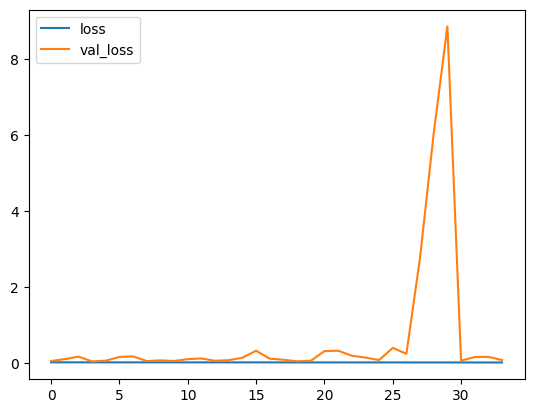

In [390]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [391]:
preds = model.predict(X_test)

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [392]:
preds = scaler2.inverse_transform(preds)

In [393]:
mean_squared_error(Y_test, preds), mean_absolute_error(Y_test, preds), r2_score(Y_test, preds)

(593565863.5944507, 15725.069136785365, -0.05457466249216658)

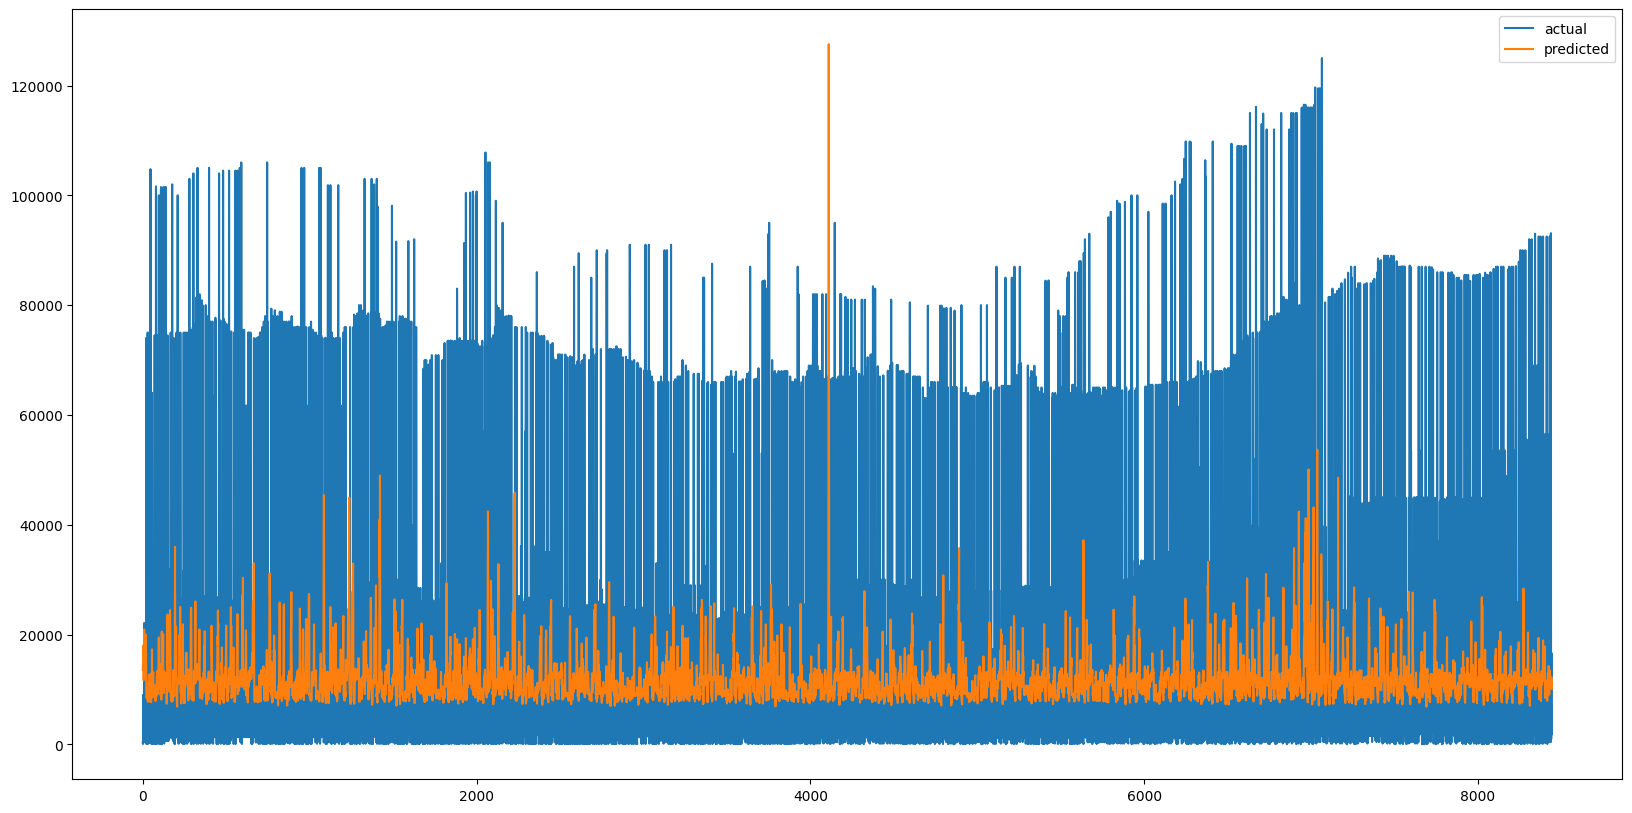

In [394]:
plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()